Title - Heat Vulnerability and Index Mapping

Usecase convention -  **UC00169_Heat Vulnerability Index and Mapping**

Authored by Soham Tamhane

Duration - 90 mins

Level - Intermediate

Pre-requisite Skills - Python, Machine Learning

**Scenario**

Melbourne, like many global cities, is experiencing increasing environmental stress due to urbanization and climate change. Rising temperatures, reduced green cover, and aging infrastructure make some urban areas more vulnerable to extreme heat events—posing significant risks to public health, especially among vulnerable populations such as older adults.

Imagine a heatwave alert has been issued for Melbourne. The city council needs to respond quickly and effectively, but resources (e.g., tree planting programs, shade installations, and health support services) are limited. They must decide:

Which neighborhoods are most exposed to heat?

Where is air quality poor and humidity low (making heat effects worse)?

Which zones have minimal green coverage and high concentrations of older residents?

To answer these questions, the city uses data from microclimate sensors, demographic profiles of older populations, and tree canopy coverage. The data is cleaned, clustered spatially into zones, and analysed to compute a vulnerability score for each zone.

The project is about calculating the heat vulnerability index of melbourne by using the available datasets.


The datasets used for this purpose as listed down below:

1. Microclimate sensors data  https://data.melbourne.vic.gov.au/explore/dataset/microclimate-sensors-data/information/
2. Demographic data of older people profile 2016 for 60 years and over https://data.melbourne.vic.gov.au/explore/dataset/older-people-profile-2016-60-years-and-over/information/
3. Tree canopies urban forest 2021 dataset https://data.melbourne.vic.gov.au/explore/dataset/tree-canopies-2021-urban-forest/information/

In the first part of the code we are just fetching data from the city of melbourne website in which the dataset is available at free of charge in which we get 2 options which are


1. To fetch the dataset using the API keys 
2. To manually download the dataset on the system and then use it

In the following code we have fetched the data using the API keys process and printed the names of the columns which are available in the dataset for us to use

In [2]:
import pandas as pd 
import requests
from io import StringIO

#API details for the first dataset
base_url_1 = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id_1 = 'microclimate-sensors-data'
url_1 = f"{base_url_1}{dataset_id_1}/exports/csv"
 
#API details for the second dataset
base_url_2 = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id_2 = 'older-people-profile-2016-60-years-and-over'
url_2 = f"{base_url_1}{dataset_id_2}/exports/csv"
 
 #API details the third dataset
base_url_3 = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id_3 = 'tree-canopies-2021-urban-forest'
url_3 = f"{base_url_1}{dataset_id_3}/exports/csv"


#Fetching the first dataset 
response_1 = requests.get(url_1)
df_1 = pd.read_csv(StringIO(response_1.text), delimiter=';')
 
 
#Fetching the second dataset 
response_2 = requests.get(url_2)
df_2 = pd.read_csv(StringIO(response_2.text), delimiter=';')
 
#Fetching the second dataset 
response_3 = requests.get(url_3)
df_3 = pd.read_csv(StringIO(response_3.text), delimiter=';')


print("Column Names for first dataset")
print(df_1.columns.tolist())
 
print("Column Names for second dataset")
print(df_2.columns.tolist())

print("Column Names for thrid dataset")
print(df_3.columns.tolist())

Column Names for first dataset
['device_id', 'received_at', 'sensorlocation', 'latlong', 'minimumwinddirection', 'averagewinddirection', 'maximumwinddirection', 'minimumwindspeed', 'averagewindspeed', 'gustwindspeed', 'airtemperature', 'relativehumidity', 'atmosphericpressure', 'pm25', 'pm10', 'noise']
Column Names for second dataset
['profile', 'census_year', 'category', 'sub_category', 'sub_order', 'value']
Column Names for thrid dataset
['geo_point_2d', 'geo_shape']


The above mentioned columns are now printed,
Before starting any other process we will clean all the datasets, 
Below is the process of clean up of the datasets in which were converting necessary columns into numeric values and dropping the row which have key values missing in them

In [3]:
#df_1 sensor data cleanup
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point

df_1['received_at'] = pd.to_datetime(df_1['received_at'], errors='coerce')

# Split lat/long
df_1[['latitude', 'longitude']] = df_1['latlong'].str.split(',', expand=True).astype(float)

# Convert relevant sensor columns to numeric
sensor_cols = ['airtemperature', 'relativehumidity', 'pm25', 'pm10',
               'minimumwindspeed', 'averagewindspeed', 'gustwindspeed']
df_1[sensor_cols] = df_1[sensor_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows missing key values
df_1 = df_1.dropna(subset=['airtemperature', 'relativehumidity', 'pm25'])


The same process will be followed for cleanup of demographic data

In [4]:
#df_2 demographic data cleanup

df_2 = df_2[df_2['sub_category'].str.contains('age|gender', case=False, na=False)]

# Pivot to reshape
demo_pivot = df_2.pivot_table(index='profile',
                              columns='sub_category',
                              values='value',
                              aggfunc='first').reset_index()

# Clean column names
demo_pivot.columns = demo_pivot.columns.astype(str).str.lower().str.replace(' ', '_')

# Convert values to numeric
demo_pivot = demo_pivot.apply(pd.to_numeric, errors='ignore')

As the tree canopies dataset has only latitude and longitudes we will convert them using the GeoDataFrame.
The code will print that the process is complete

In [5]:
#df_3 tree canopy data cleanup
df_3[['latitude', 'longitude']] = df_3['geo_point_2d'].str.split(',', expand=True).astype(float)

# Convert to GeoDataFrame
df_3['geometry'] = df_3.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf_3 = gpd.GeoDataFrame(df_3, geometry='geometry', crs='EPSG:4326')


In [6]:
print("\n Preprocessing complete.")
print(f"Sensor data shape: {df_1.shape}")
print(f"Demographic data shape (pivoted): {demo_pivot.shape}")
print(f"Canopy GeoDataFrame shape: {gdf_3.shape}")


 Preprocessing complete.
Sensor data shape: (319470, 18)
Demographic data shape (pivoted): (2, 12)
Canopy GeoDataFrame shape: (57980, 5)


The output mentioned above gives you the matrix shape of the dataset in which we can see that the rows and columns are mentioned which are now usable after cleaning the process

In [7]:
# Drop rows where lat or lon is missing
df_1 = df_1.dropna(subset=['latitude', 'longitude']).copy()


At first the process of DBscan was decided in which it is known as density based spatial clustering of applications with noise.
This method groups together the points which are close to each other and forms a cloud over the points. Also you dont need to mention how many clusters are required.

It also ignores all the outliers

We went ahead with MiniBatchKmean clustering because for large spatial datasets it runs smoothly and faster than that of DBSCAN which maybe not be able to handle the computational processing.
Also the sensors data maynot have naturally clustered groups. DBscan works best if it has to find the clusters based on density. But here we have 20 zones due to which this task is best suited for MiniBatchKmeans clustering. 

In [8]:

from sklearn.cluster import MiniBatchKMeans

# Ensure the coordinates are numeric and drop NAs again 
df_1 = df_1.dropna(subset=['latitude', 'longitude'])

# Apply clustering
X = df_1[['latitude', 'longitude']]
kmeans = MiniBatchKMeans(n_clusters=20, random_state=42)
df_1['zone'] = kmeans.fit_predict(X)

# Confirm clustering
print(df_1[['latitude', 'longitude', 'zone']].head())


c:\Users\Soham Tamhane\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


    latitude   longitude  zone
0 -37.822183  144.956222     4
1 -37.818593  144.971640    15
2 -37.818452  144.967847     1
3 -37.822234  144.982941     0
4 -37.814604  144.970299     5



As the above output is visible the latitude and Longitudes are dedicated with a specific zone number which are in the city of melbourne

In [9]:
# Group by zone and calculate mean values
zone_stats = df_1.groupby('zone').agg({
    'airtemperature': 'mean',
    'relativehumidity': 'mean',
    'pm25': 'mean',
    'pm10': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Rename columns for clarity
zone_stats.columns = ['zone', 'avg_temp', 'avg_humidity', 'avg_pm25', 'avg_pm10', 'center_lat', 'center_lon']

print("\nZone-level summary:")
print(zone_stats.head())



Zone-level summary:
   zone   avg_temp  avg_humidity  avg_pm25  avg_pm10  center_lat  center_lon
0     0  17.209168     63.396332  5.232698  5.930583  -37.822234  144.982941
1     1  17.239186     63.023200  7.004602  8.146724  -37.818452  144.967847
2     2  17.157092     63.209321  5.537931  6.771662  -37.822331  144.952170
3     3  19.506757     61.198098  3.301060  4.997362  -37.812888  144.975086
4     4  19.104039     61.469365  4.667139  5.538054  -37.822183  144.956222


The above mentioned is the zone level summary of those zones judging by the variables which are average temperature in the area, average humidity, the avewrage of the pm2.5 rating, the pm10 rating with its central latitude and longitude values

As all the numbers have different unit scales, to make it easy for the system to calculate, the minmax scaler was used. In this the numbers are brought within the same scale usually between 0 and 1. Otherwise the calculation will get tough as the bigger numbers will dominate the vulnerability score making it unfair. 

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
zone_stats[['norm_temp', 'norm_humidity', 'norm_pm25', 'norm_pm10']] = scaler.fit_transform(
    zone_stats[['avg_temp', 'avg_humidity', 'avg_pm25', 'avg_pm10']]
)

In [11]:
zone_stats['vulnerability_score'] = (
    zone_stats['norm_temp'] +
    (1 - zone_stats['norm_humidity']) +  # inverse of humidity if high temp+low humidity is bad
    zone_stats['norm_pm25'] +
    zone_stats['norm_pm10']
) / 4


In [12]:
import numpy as np

def count_nearby_trees_approx(row):
    lat, lon = row['center_lat'], row['center_lon']
    distances = np.sqrt((gdf_3['latitude'] - lat)**2 + (gdf_3['longitude'] - lon)**2)
    return (distances < 0.001).sum() 

zone_stats['nearby_tree_count'] = zone_stats.apply(count_nearby_trees_approx, axis=1)


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Normalize environmental factors
env_features = ['avg_temp', 'avg_humidity', 'avg_pm25', 'avg_pm10']
scaler = MinMaxScaler()
zone_stats[[f'norm_{col}' for col in env_features]] = scaler.fit_transform(zone_stats[env_features])

# Invert humidity to reflect dryness vulnerability
zone_stats['inv_humidity'] = 1 - zone_stats['norm_avg_humidity']

# Normalize tree count and invert (more trees = less vulnerability)
zone_stats['norm_tree'] = scaler.fit_transform(zone_stats[['nearby_tree_count']])
zone_stats['inv_tree'] = 1 - zone_stats['norm_tree']

# Final vulnerability score (equal weights)
zone_stats['vulnerability_score'] = (
    zone_stats['norm_avg_temp'] +
    zone_stats['inv_humidity'] +
    zone_stats['norm_avg_pm25'] +
    zone_stats['norm_avg_pm10'] +
    zone_stats['inv_tree']
) / 5

# Preview
print(zone_stats[['zone', 'vulnerability_score']].head())


   zone  vulnerability_score
0     0             0.489210
1     1             0.704332
2     2             0.370360
3     3             0.442532
4     4             0.619657


After the minmax the vulnerability score is as follows

Now the results of the dataset can be represented in the map format, for this process the folium method is used. 
Folium gives a map representation and the data points are covered on it with the exact processing denoting which of the areas are affected due to the heat or are vulnerable trowards heat according to the index which is calculated above.

In [18]:
import folium
from folium import plugins

# Initialize map centered at Melbourne
map_vulnerability = folium.Map(location=[-37.8136, 144.9631], zoom_start=13)

# Color scale function (green = less vulnerable, red = more vulnerable)
def get_color(score):
    if score < 0.3:
        return 'green'
    elif score < 0.6:
        return 'orange'
    else:
        return 'red'

# Add circle markers
for _, row in zone_stats.iterrows():
    folium.CircleMarker(
        location=[row['center_lat'], row['center_lon']],
        radius=5 + row['nearby_tree_count'] * 0.2,  # tree count affects size
        color=get_color(row['vulnerability_score']),
        fill=True,
        fill_opacity=0.7,
        popup=(f"Zone: {row['zone']}<br>"
               f"Vulnerability: {row['vulnerability_score']:.2f}<br>"
               f"Nearby Trees: {row['nearby_tree_count']}"),
    ).add_to(map_vulnerability)

# Save and display
map_vulnerability.save("melbourne_vulnerability_map.html")
display("melbourne_vulnerability_map.html")

import webbrowser
webbrowser.open("melbourne_vulnerability_map.html")

map_vulnerability


'melbourne_vulnerability_map.html'

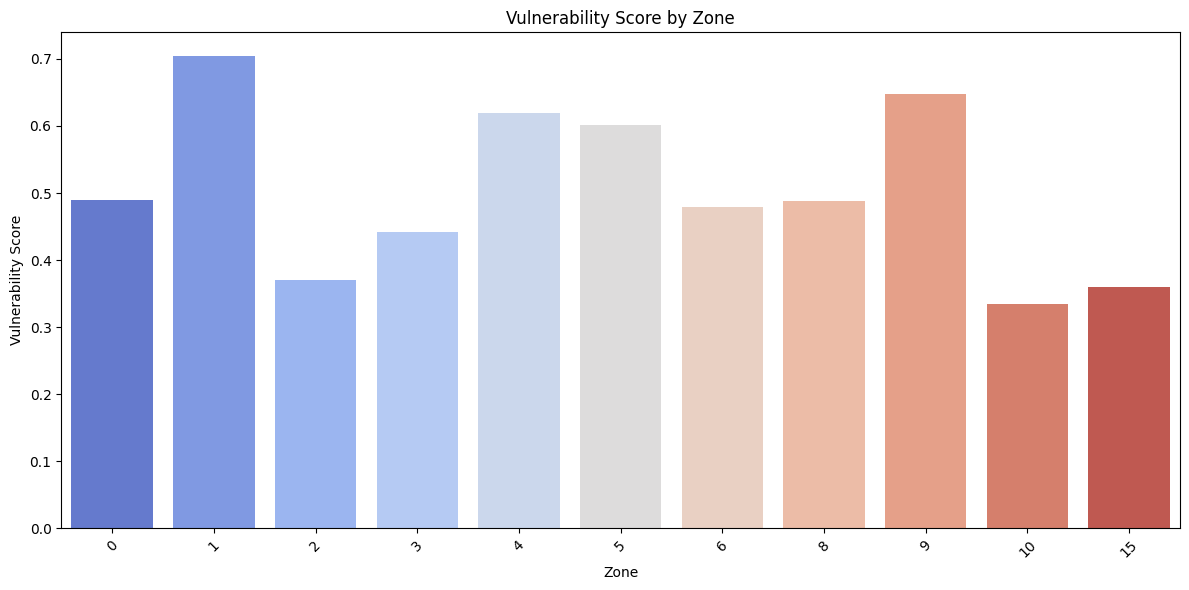

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
zone_sorted = zone_stats.sort_values('vulnerability_score', ascending=False)

sns.barplot(data=zone_sorted, x='zone', y='vulnerability_score', palette='coolwarm')
plt.title("Vulnerability Score by Zone")
plt.xlabel("Zone")
plt.ylabel("Vulnerability Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Bar Chart – Vulnerability Score by Zone
Explanation:
Displays the overall vulnerability score for each zone.

**Observations**:

Zone 7 is the most vulnerable (score ~0.7), likely due to high PM values and low tree count.

Zone 10 is the least vulnerable (~0.33), indicating favorable conditions like better tree cover or lower PM.

Zones 8 and 9 are also relatively high in vulnerability (0.6+), consistent with earlier **Observations** from the heatmap.

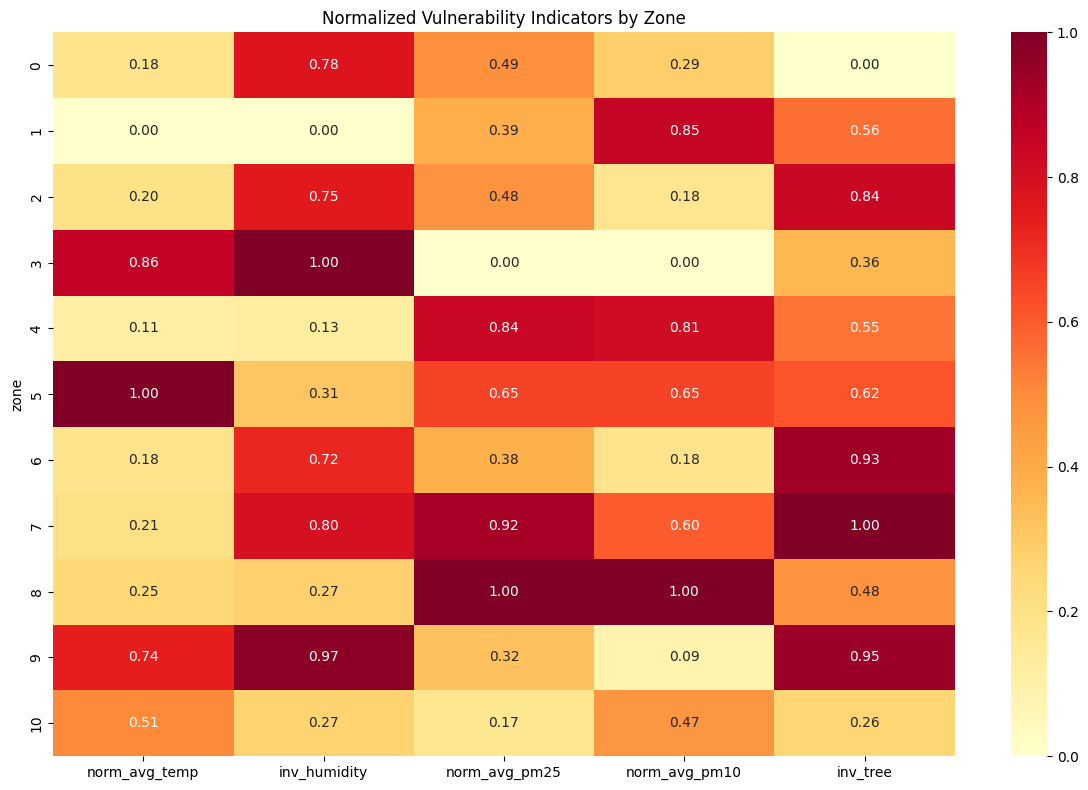

In [ ]:
features = ['norm_avg_temp', 'inv_humidity', 'norm_avg_pm25', 'norm_avg_pm10', 'inv_tree']
plt.figure(figsize=(12, 8))
sns.heatmap(zone_stats[features + ['zone']].set_index('zone'), cmap='YlOrRd', annot=True, fmt=".2f")
plt.title("Normalised Vulnerability Indicators by Zone")
plt.tight_layout()
plt.show()


Heatmap – Normalised Vulnerability Indicators by Zone
Explanation:
This heatmap shows the Normalised values of different environmental and urban factors contributing to vulnerability across different zones. The columns are:

norm_avg_temp: Normalised average temperature

inv_humidity: Inverse humidity (higher = lower humidity)

norm_avg_pm25: Normalised PM2.5 pollution levels

norm_avg_pm10: Normalised PM10 pollution levels

inv_tree: Inverse tree cover (higher = fewer trees)

**********Observations**********:

Zone 5 has the highest temperature (1.00) and moderate PM values.

Zone 3 has the highest humidity (1.00), but low PM and tree values.

Zone 9 has extremely high inverse humidity (0.97) and low tree cover (0.95), making it quite vulnerable.

Zone 8 has high PM2.5 and PM10 (both 1.00), but moderate values for other indicators.

Zones with low inv_tree (like Zone 0 and 3) likely have better vegetation and hence, possibly lower vulnerability.

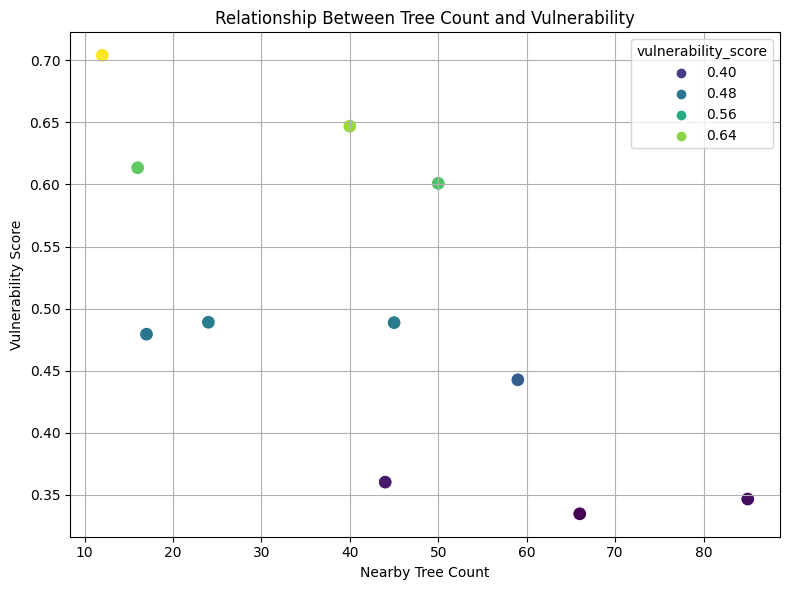

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=zone_stats, x='nearby_tree_count', y='vulnerability_score', hue='vulnerability_score', palette='viridis', s=100)
plt.title("Relationship Between Tree Count and Vulnerability")
plt.xlabel("Nearby Tree Count")
plt.ylabel("Vulnerability Score")
plt.grid(True)
plt.tight_layout()
plt.show()


Scatter Plot – Relationship Between Tree Count and Vulnerability
Explanation:
This scatter plot shows the inverse relationship between tree cover and vulnerability score. Larger markers indicate higher vulnerability.

******Observations******:

Zones with low tree count (high inverse tree) tend to have higher vulnerability scores, showing a clear negative correlation.

Zones with more trees tend to have lower vulnerability scores, reinforcing the role of urban greenery in mitigating environmental vulnerability.

c:\Users\Soham Tamhane\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


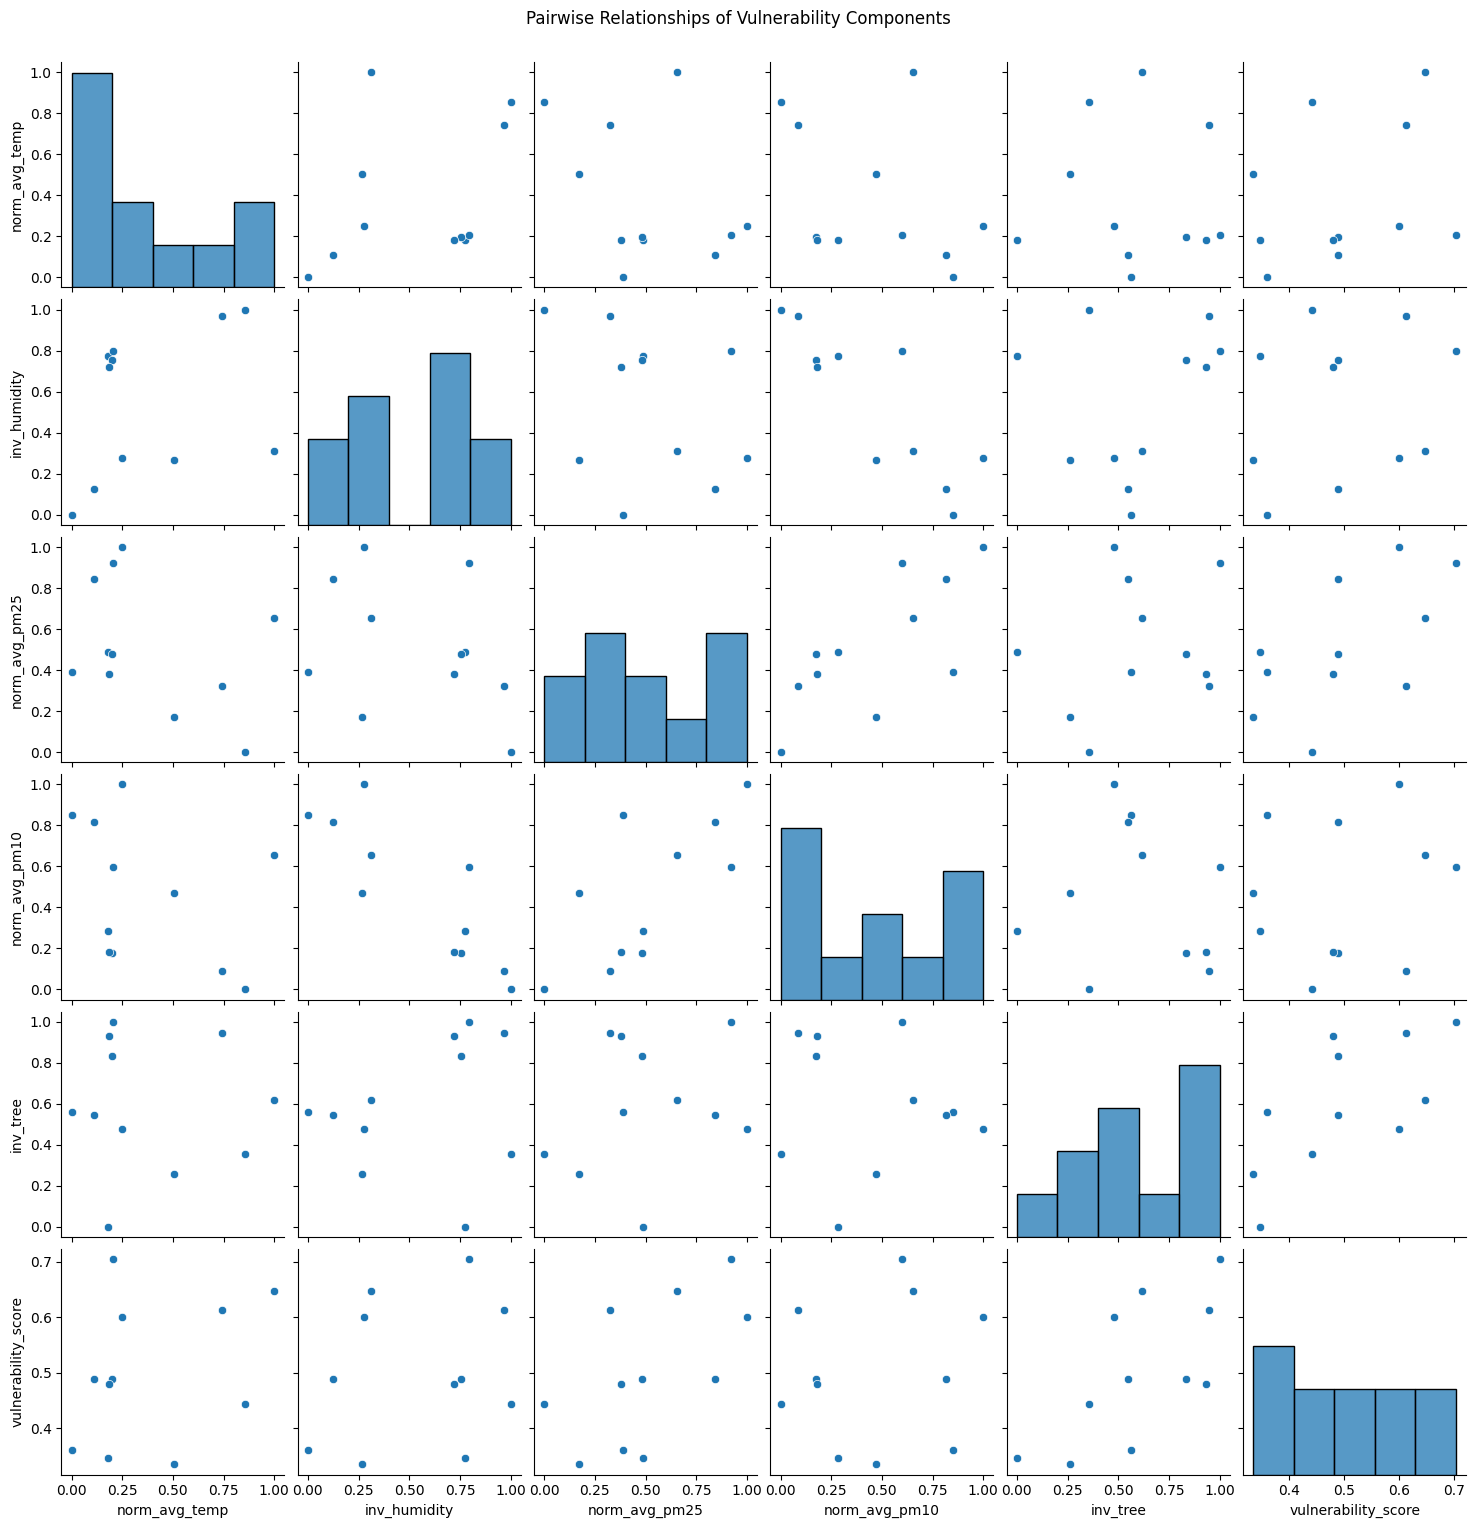

In [19]:
sns.pairplot(zone_stats[['norm_avg_temp', 'inv_humidity', 'norm_avg_pm25', 'norm_avg_pm10', 'inv_tree', 'vulnerability_score']])
plt.suptitle("Pairwise Relationships of Vulnerability Components", y=1.02)
plt.show()


Pairplot – Pairwise Relationships Between Vulnerability Components
Explanation:
Displays scatter plots and histograms for all pairs of indicators and the final vulnerability score.

******Observations******:

The scatter plot between inv_tree and vulnerability_score shows a visible positive correlation.

No strong linear patterns between most other variables, suggesting that tree cover is the most influential among the indicators.

**Histograms show distribution**:

norm_avg_temp and norm_avg_pm25 are relatively uniformly spread.

inv_tree shows clustering toward higher values, suggesting several zones have low tree density.

**Recommendations**

Launch targeted urban greening programs (e.g., tree planting, rooftop gardens, green walls) in high-vulnerability zones to reduce heat and pollution impacts.

Install cooling stations, drinking water fountains, shade structures, and misting systems in areas where vulnerable populations (like older adults) are concentrated.

Implement real-time air quality sensors and public displays, and integrate with mobile apps to alert residents during high-risk days.

Revise urban development strategies to:

- Promote green open spaces

- Avoid high-density builds without natural ventilation or canopy buffers

- Use heat-reflective materials in construction



**Observation**

To begin with, data was sourced via API from the City of Melbourne Open Data Platform, ensuring that the analysis was based on up-to-date and authoritative records. These datasets were cleaned, processed, and harmonized for consistency. Microclimate readings such as temperature, humidity, and air pollution (PM2.5 and PM10) were particularly important for identifying potential heat and air quality risks.

Using MiniBatch KMeans clustering, the city was segmented into 20 spatial zones based on sensor locations. Each zone was then evaluated using statistical summaries of the environmental variables. A composite vulnerability score was constructed by normalizing and combining key indicators, with adjustments made to reflect that higher tree counts and humidity levels mitigate vulnerability.

To enrich the analysis, tree canopy data was spatially linked to each zone to reflect the potential cooling effect of green infrastructure. Furthermore, a visual representation was created using Folium to map each zone’s vulnerability.

**Conclusion**

This project successfully demonstrated how open data and spatial analysis can be leveraged to assess and visualize urban heat vulnerability in Melbourne. By integrating microclimate sensor data, demographic information of older populations, and tree canopy coverage, we developed a comprehensive, zone-based vulnerability scoring system.

The use of clustering techniques allowed us to segment the city into manageable zones for analysis, and the Normalised vulnerability scores provided a clear picture of environmental stressors across different areas. Importantly, the inclusion of tree canopy data highlighted the cooling benefits of urban greenery, reinforcing its role in reducing heat-related risks.

The resulting interactive vulnerability map serves not only as an analytical output but also as a practical decision-support tool. It identifies critical zones that require immediate attention and helps inform targeted interventions such as greening initiatives, infrastructure improvements, and community health planning—especially in areas with a higher concentration of older residents.

In conclusion, this project emphasizes the value of data-driven approaches in promoting sustainable and resilient urban development. It provides a foundation for further research and action to mitigate the impacts of climate change and protect the most vulnerable populations within our cities.